In [1]:
%pip install pandas imblearn scikit-learn scikit-fuzzy matplotlib tensorflow numpy==1.23 mne


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from collections import Counter



In [3]:
# Load the uploaded dataset
file_path = '../data/preprocessed_motor_imagery_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
df.head()

,TimeStamp,Event_Count,Task_Labels,File_ID,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,...,Alpha_AF8,Alpha_TP10,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10
0,2024-06-22 18:31:11.748,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.373702,0.792392,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156
1,2024-06-22 18:31:11.749,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.373702,0.792392,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156
2,2024-06-22 18:31:11.750,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.373702,0.792392,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156
3,2024-06-22 18:31:11.751,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.373702,0.792392,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156
4,2024-06-22 18:31:11.752,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.373702,0.792392,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156


In [4]:
df.shape

(406456, 24)

/Users/kabanda/Documents/unifr/SA2024/fuzzy_project/.venv/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/kabanda/Documents/unifr/SA2024/fuzzy_project/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


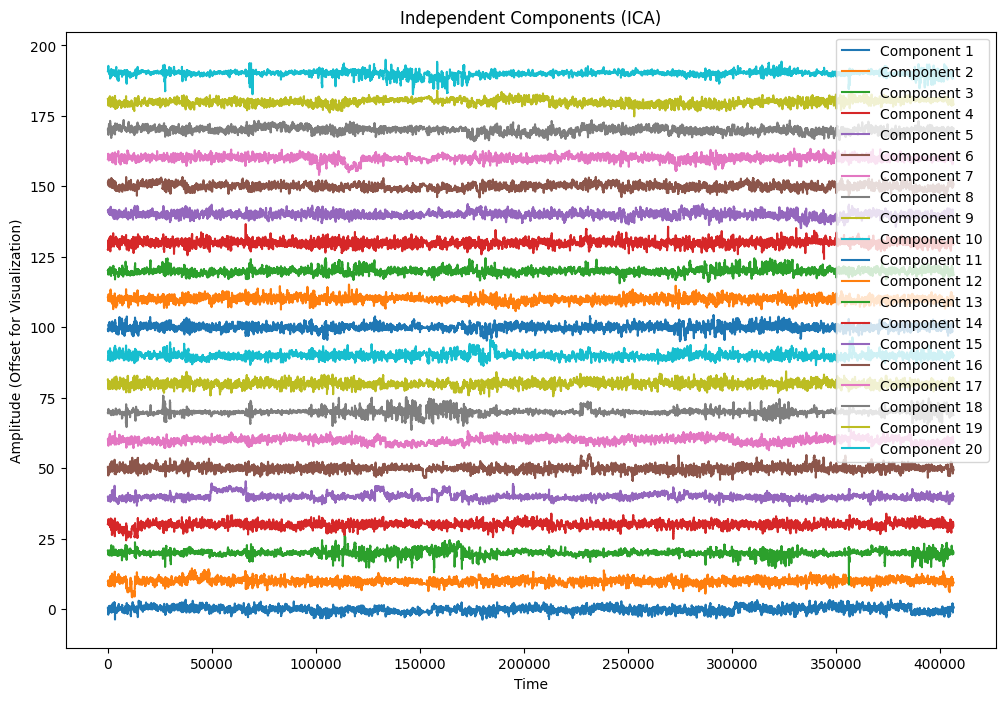

In [5]:
# Extract EEG feature columns (excluding metadata)
eeg_columns = [col for col in df.columns if 'TP' in col or 'AF' in col]
eeg_data = df[eeg_columns]

# Apply ICA to EEG data
ica = FastICA(n_components=len(eeg_columns), random_state=42)
ica_components = ica.fit_transform(eeg_data)  # Independent components

# Plot the independent components to identify artifacts
plt.figure(figsize=(12, 8))
for i in range(len(eeg_columns)):
    plt.plot(ica_components[:, i] + i * 10, label=f'Component {i + 1}')

plt.title('Independent Components (ICA)')
plt.xlabel('Time')
plt.ylabel('Amplitude (Offset for Visualization)')
plt.legend()
plt.show()

In [6]:
# Identify gaps that occur within the same Event_Count and File_ID
df['Same_Event_File'] = (df['Event_Count'] == df['Event_Count'].shift(1)) & (
    df['File_ID'] == df['File_ID'].shift(1)
)

threshold = 1000  # in milliseconds

# Ensure TimeStamp is in datetime format
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

df['Time_Diff'] = df['TimeStamp'].diff().dt.total_seconds() * 1000


# Focus on gaps that occur within the same event and file
meaningful_gaps = df[(df['Time_Diff'] > threshold) & df['Same_Event_File']]

# Display these meaningful gaps
meaningful_gaps

,TimeStamp,Event_Count,Task_Labels,File_ID,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,...,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Same_Event_File,Time_Diff
133047,2024-06-05 17:37:26.832,Relax_001,Relax,file_14,1.186281,1.138327,1.021089,0.955847,0.466930,0.397054,...,0.363170,0.407117,0.110397,0.383598,-0.087284,0.400445,-0.049058,0.080393,True,42642.0
185945,2024-06-20 16:41:32.715,Right_002,Right,file_15,0.957527,2.155523,1.332785,1.843651,0.702194,1.249188,...,0.531487,0.820123,0.291247,0.883632,0.126251,0.216861,-0.059578,0.536281,True,11433.0


In [7]:
# Identify events and files with significant gaps to exclude
events_to_exclude = meaningful_gaps[['Event_Count', 'File_ID']].drop_duplicates()

# Filter out rows with the identified Event_Count and File_ID
filtered_data = df[
    ~df.set_index(['Event_Count', 'File_ID']).index.isin(
        events_to_exclude.set_index(['Event_Count', 'File_ID']).index
    )
]

# Display the shape of the data before and after filtering
original_shape = df.shape
filtered_shape = filtered_data.shape

original_shape, filtered_shape


((406456, 26), (398507, 26))

In [8]:
# Update the threshold to identify gaps larger than 0.1 second (100 ms)
threshold = 100  # in milliseconds

# Focus on gaps greater than 0.1 second within the same event and file
small_gaps = df[(df['Time_Diff'] > threshold) & df['Same_Event_File']]

# Display the results for these gaps
small_gaps


,TimeStamp,Event_Count,Task_Labels,File_ID,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,...,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Same_Event_File,Time_Diff
101,2024-06-22 18:31:12.640,Right_001,Right,file_01,-0.435340,0.182869,-0.116291,0.093227,0.150177,0.030288,...,0.097952,-0.078184,-0.012508,0.211106,-0.243970,-0.434849,-0.435106,-0.105003,True,101.0
470,2024-06-22 18:31:15.537,Right_001,Right,file_01,0.366489,-0.299339,-0.153057,0.364644,0.212452,-0.118311,...,0.144248,-0.141304,-0.187668,0.203466,-0.357806,-0.682133,-0.639210,-0.236963,True,101.0
507,2024-06-22 18:31:15.853,Right_001,Right,file_01,0.670615,-0.124682,-0.172953,0.524281,0.284488,-0.100995,...,0.147059,-0.098401,-0.200711,0.199413,-0.327256,-0.579846,-0.616040,-0.182291,True,147.0
914,2024-06-22 18:31:18.905,Right_001,Right,file_01,0.530684,-0.265979,-0.052191,0.405122,-0.012133,-0.130798,...,0.043797,-0.191103,-0.108776,0.294890,-0.337921,-0.467795,-0.294310,-0.149418,True,130.0
1036,2024-06-22 18:34:03.959,Relax_001,Relax,file_01,1.351853,0.097560,0.394204,0.877307,1.153880,0.187630,...,0.723964,-0.073782,-0.043452,0.576385,-0.009938,-0.508554,-0.336678,0.235174,True,101.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405738,2024-06-23 03:47:25.043,Left_001,Left,file_30,1.129762,0.284483,0.096976,0.907097,0.801618,0.107873,...,0.464531,0.013885,-0.074410,0.380732,0.111611,-0.324855,-0.276263,0.195607,True,138.0
405923,2024-06-23 03:47:26.151,Left_001,Left,file_30,1.074296,0.471322,1.084881,0.871671,0.706872,0.180368,...,0.381944,-0.050934,-0.055221,0.446200,-0.017738,-0.355195,-0.377928,0.079939,True,126.0
406095,2024-06-23 03:53:40.515,Right_002,Right,file_30,0.538589,-0.311331,0.246552,0.562349,0.400531,-0.327192,...,0.412111,0.086460,-0.152154,0.538190,0.070798,-0.328908,-0.496566,0.257744,True,103.0
406127,2024-06-23 03:53:40.764,Right_002,Right,file_30,0.430499,-0.278254,0.200529,0.505845,0.288977,-0.310915,...,0.341777,0.020561,-0.175655,0.473076,-0.004351,-0.352070,-0.487638,0.211776,True,101.0


In [9]:
# Function to interpolate small gaps with explicit handling of labels and NaN values
def robust_interpolation(df, threshold=100):
    """
    Interpolates small gaps in EEG data while preserving meaningful labels and avoiding NaN values.
    """
    # Identify rows where interpolation is needed
    df['Interpolate'] = (df['Time_Diff'] > threshold) & df['Same_Event_File']
    
    # Interpolate numerical columns
    for col in df.columns:
        if col not in ['TimeStamp', 'Event_Count', 'Task_Labels', 'File_ID', 'Time_Diff', 'Mean_Time_Diff', 'Same_Event_File', 'Interpolate']:
            df[col] = df[col].interpolate(method='linear', limit_direction='both', axis=0)
    
    # Verify and handle NaN values explicitly
    df = df.fillna(method='bfill').fillna(method='ffill')  # Backfill and forward-fill any remaining NaN values
    
    # Drop the temporary column used for marking interpolation
    df = df.drop(columns=['Interpolate'])
    
    return df

# Apply robust interpolation
df = robust_interpolation(df.copy(), threshold=100)

# Check if there are any remaining NaN values
nan_check = df.isnull().sum().sum()

# Verify remaining gaps above the threshold
remaining_small_gaps = df[
    (df['Time_Diff'] > 100) & df['Same_Event_File']
]

# Output results
df.shape, nan_check, remaining_small_gaps.shape


/var/folders/tx/77vvk3p5295f2xy_6rvn37y00000gn/T/ipykernel_20644/1792008940.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')  # Backfill and forward-fill any remaining NaN values


((406456, 26), 0, (4255, 26))

In [10]:
df

,TimeStamp,Event_Count,Task_Labels,File_ID,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,...,Beta_TP9,Beta_AF7,Beta_AF8,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Same_Event_File,Time_Diff
0,2024-06-22 18:31:11.748,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,False,1.0
1,2024-06-22 18:31:11.749,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,True,1.0
2,2024-06-22 18:31:11.750,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,True,1.0
3,2024-06-22 18:31:11.751,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,True,1.0
4,2024-06-22 18:31:11.752,Right_001,Right,file_01,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,...,0.116549,-0.015092,-0.018954,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406451,2024-06-23 03:59:37.652,Left_002,Left,file_30,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,...,0.164039,0.024965,-0.037325,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,True,30.0
406452,2024-06-23 03:59:37.653,Left_002,Left,file_30,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,...,0.164039,0.024965,-0.037325,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,True,1.0
406453,2024-06-23 03:59:37.654,Left_002,Left,file_30,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,...,0.164039,0.024965,-0.037325,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,True,1.0
406454,2024-06-23 03:59:37.655,Left_002,Left,file_30,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,...,0.164039,0.024965,-0.037325,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,True,1.0


In [11]:
# Check the distinct types of events in the Event_Count column and their counts
distinct_events = df['Event_Count'].value_counts()

# Display the results
distinct_events


Event_Count
Relax_004    69474
Relax_001    68204
Relax_003    61004
Relax_002    60380
Right_002    32703
Relax_005    24849
Right_001    23599
Left_002     21895
Left_001     12433
Right_004     8121
Left_003      7238
Relax_006     6168
Relax_007     5259
Right_003     3083
Right_005      978
Left_004       435
Left_005       385
Left_006        87
Relax_009       84
Relax_008       77
Name: count, dtype: int64

In [12]:
def resample_and_align_labels_per_event(data, target_freq=256):
    """
    Resamples EEG data and aligns labels within each event boundary.
    """
    resampled_data = []

    # Resample each event separately
    unique_events = data[['Event_Count', 'Task_Labels', 'File_ID']].drop_duplicates()
    for _, event in unique_events.iterrows():
        event_data = data[
            (data['Event_Count'] == event['Event_Count']) &
            (data['Task_Labels'] == event['Task_Labels']) &
            (data['File_ID'] == event['File_ID'])
        ]
        
        # Calculate the new time axis for this event
        start_time = event_data['TimeStamp'].iloc[0]
        end_time = event_data['TimeStamp'].iloc[-1]
        new_time_axis = pd.date_range(start=start_time, end=end_time, freq=f'{1000 / target_freq}ms')

        # Resample numerical columns
        resampled_event_data = pd.DataFrame({'TimeStamp': new_time_axis})
        for col in event_data.columns:
            if col not in ['TimeStamp', 'Event_Count', 'Task_Labels', 'File_ID']:
                resampled_event_data[col] = np.interp(
                    new_time_axis.astype(np.int64) / 1e6,  # Convert to ms for interpolation
                    event_data['TimeStamp'].astype(np.int64) / 1e6,
                    event_data[col]
                )
        
        # Add labels to the resampled data
        resampled_event_data['Event_Count'] = event['Event_Count']
        resampled_event_data['Task_Labels'] = event['Task_Labels']
        resampled_event_data['File_ID'] = event['File_ID']

        resampled_data.append(resampled_event_data)

    # Combine all resampled events
    resampled_data = pd.concat(resampled_data, ignore_index=True)

    return resampled_data

# Apply the improved resampling and alignment function
data_resampled_corrected = resample_and_align_labels_per_event(df, target_freq=256)

# Check for NaN values and display the first few rows of the corrected dataset
nan_check_corrected = data_resampled_corrected.isnull().sum().sum()
data_resampled_corrected.shape, nan_check_corrected, data_resampled_corrected.head()

((839944, 26),
 0,
                       TimeStamp  Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  \
 0 2024-06-22 18:31:11.748000000   0.102685  -0.202962  -0.000793   -0.022647   
 1 2024-06-22 18:31:11.751906250   0.102685  -0.202962  -0.000793   -0.022647   
 2 2024-06-22 18:31:11.755812500   0.100581  -0.203067  -0.002264   -0.025448   
 3 2024-06-22 18:31:11.759718750   0.097659  -0.203211  -0.004308   -0.029339   
 4 2024-06-22 18:31:11.763625000   0.094737  -0.203356  -0.006352   -0.033229   
 
    Theta_TP9  Theta_AF7  Theta_AF8  Theta_TP10  Alpha_TP9  ...  Beta_TP10  \
 0   0.190827  -0.119497  -0.015302    0.057319   0.406395  ...   0.238557   
 1   0.190827  -0.119497  -0.015302    0.057319   0.406395  ...   0.238557   
 2   0.190737  -0.121012  -0.015657    0.055005   0.407113  ...   0.238112   
 3   0.190612  -0.123117  -0.016150    0.051791   0.408109  ...   0.237495   
 4   0.190486  -0.125222  -0.016643    0.048578   0.409105  ...   0.236877   
 
    Gamma_TP9  Gamma_AF

In [13]:
data_resampled_corrected

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Same_Event_File,Time_Diff,Event_Count,Task_Labels,File_ID
0,2024-06-22 18:31:11.748000000,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,-0.015302,0.057319,0.406395,...,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,0.0,1.000000,Right_001,Right,file_01
1,2024-06-22 18:31:11.751906250,0.102685,-0.202962,-0.000793,-0.022647,0.190827,-0.119497,-0.015302,0.057319,0.406395,...,0.238557,-0.217079,-0.477661,-0.416357,-0.357156,1.0,1.000000,Right_001,Right,file_01
2,2024-06-22 18:31:11.755812500,0.100581,-0.203067,-0.002264,-0.025448,0.190737,-0.121012,-0.015657,0.055005,0.407113,...,0.238112,-0.216812,-0.477647,-0.416043,-0.356673,1.0,3.727293,Right_001,Right,file_01
3,2024-06-22 18:31:11.759718750,0.097659,-0.203211,-0.004308,-0.029339,0.190612,-0.123117,-0.016150,0.051791,0.408109,...,0.237495,-0.216442,-0.477627,-0.415607,-0.356002,1.0,7.515200,Right_001,Right,file_01
4,2024-06-22 18:31:11.763625000,0.094737,-0.203356,-0.006352,-0.033229,0.190486,-0.125222,-0.016643,0.048578,0.409105,...,0.236877,-0.216071,-0.477607,-0.415171,-0.355332,1.0,11.303107,Right_001,Right,file_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839939,2024-06-23 03:59:37.638406250,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,-0.086963,-0.045417,0.740977,...,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,1.0,16.859268,Left_002,Left,file_30
839940,2024-06-23 03:59:37.642312500,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,-0.086963,-0.045417,0.740977,...,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,1.0,20.635340,Left_002,Left,file_30
839941,2024-06-23 03:59:37.646218750,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,-0.086963,-0.045417,0.740977,...,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,1.0,24.411413,Left_002,Left,file_30
839942,2024-06-23 03:59:37.650125000,0.437574,0.349698,0.405130,0.163719,0.385815,-0.130223,-0.086963,-0.045417,0.740977,...,0.154748,-0.364916,-0.363726,-0.498248,-0.340444,1.0,28.187485,Left_002,Left,file_30


In [14]:
# Check the distinct types of events in the Event_Count column and their counts
distinct_events = data_resampled_corrected['Event_Count'].value_counts()

# Display the results
distinct_events


Event_Count
Relax_001    149467
Relax_004    143459
Relax_003    126236
Relax_002    123402
Right_002     62016
Relax_005     51992
Right_001     48547
Left_002      43383
Left_001      25997
Right_004     17332
Left_003      14083
Relax_006     12539
Relax_007     11004
Right_003      6409
Right_005      1959
Left_004        842
Left_005        800
Relax_009       173
Left_006        163
Relax_008       141
Name: count, dtype: int64

In [15]:
# Check rows for a specific event
event_to_check = 'Relax_001'
sample_event_data = data_resampled_corrected[data_resampled_corrected['Event_Count'] == event_to_check]

print("Sample Event Data:\n", sample_event_data.head())
print("Timestamp Range for Event:", sample_event_data['TimeStamp'].min(), "-", sample_event_data['TimeStamp'].max())


Sample Event Data:
                          TimeStamp  Delta_TP9  Delta_AF7  Delta_AF8  \
2002 2024-06-22 18:34:03.719000000   1.351853   1.046970   0.598900   
2003 2024-06-22 18:34:03.722906250   1.351853   1.046970   0.598900   
2004 2024-06-22 18:34:03.726812500   1.351853   0.174044   0.516507   
2005 2024-06-22 18:34:03.730718750   1.351853   0.174044   0.516507   
2006 2024-06-22 18:34:03.734625000   1.351853   0.174044   0.516507   

      Delta_TP10  Theta_TP9  Theta_AF7  Theta_AF8  Theta_TP10  Alpha_TP9  ...  \
2002    0.877307    1.15388   0.382202   0.102999    0.470623   1.215436  ...   
2003    0.877307    1.15388   0.382202   0.102999    0.470623   1.215436  ...   
2004    0.877307    1.15388   0.131901   0.106847    0.470623   1.215436  ...   
2005    0.877307    1.15388   0.131901   0.106847    0.470623   1.215436  ...   
2006    0.877307    1.15388   0.131901   0.106847    0.470623   1.215436  ...   

      Beta_TP10  Gamma_TP9  Gamma_AF7  Gamma_AF8  Gamma_TP10  Same

In [16]:
gaps = sample_event_data[sample_event_data['Time_Diff'] > 1.5 * sample_event_data['Time_Diff'].mean()]
print("Gaps within the event:\n", gaps)


Gaps within the event:
                      TimeStamp  Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  \
2002   2024-06-22 18:34:03.719   1.351853   1.046970   0.598900    0.877307   
3019   2024-06-02 09:47:55.681  -0.101393   0.474535   0.878137   -0.398593   
7503   2024-06-21 01:50:04.577   0.248151   0.418417   0.853178    1.085647   
29631  2024-06-22 00:09:10.117   0.741917   0.157079   0.181985    0.985077   
72530  2024-06-22 18:44:47.628   0.540977  -0.183239   0.237442    0.526726   
...                        ...        ...        ...        ...         ...   
758073 2024-06-03 05:38:45.194   0.879597   0.856496   1.123697    0.915676   
771453 2024-06-22 19:00:58.192   1.345192   0.276738   0.880995    0.770368   
800247 2024-06-17 21:47:36.696   1.865984   2.017453   0.679041    2.254387   
835403 2024-06-21 00:03:42.400   0.150061   1.374194   0.805799    0.430872   
838277 2024-06-23 03:46:04.250   0.386172   0.279815   0.900290   -0.128410   

        Theta_TP9  Theta_AF

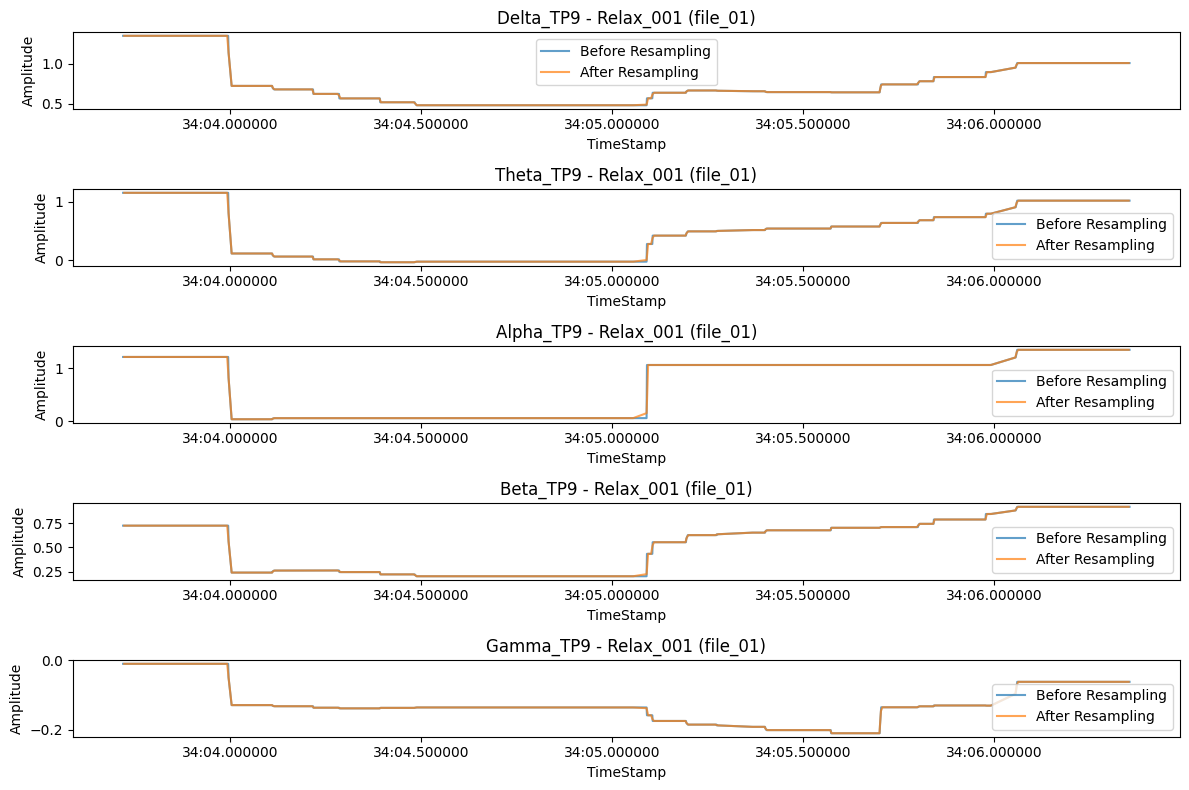

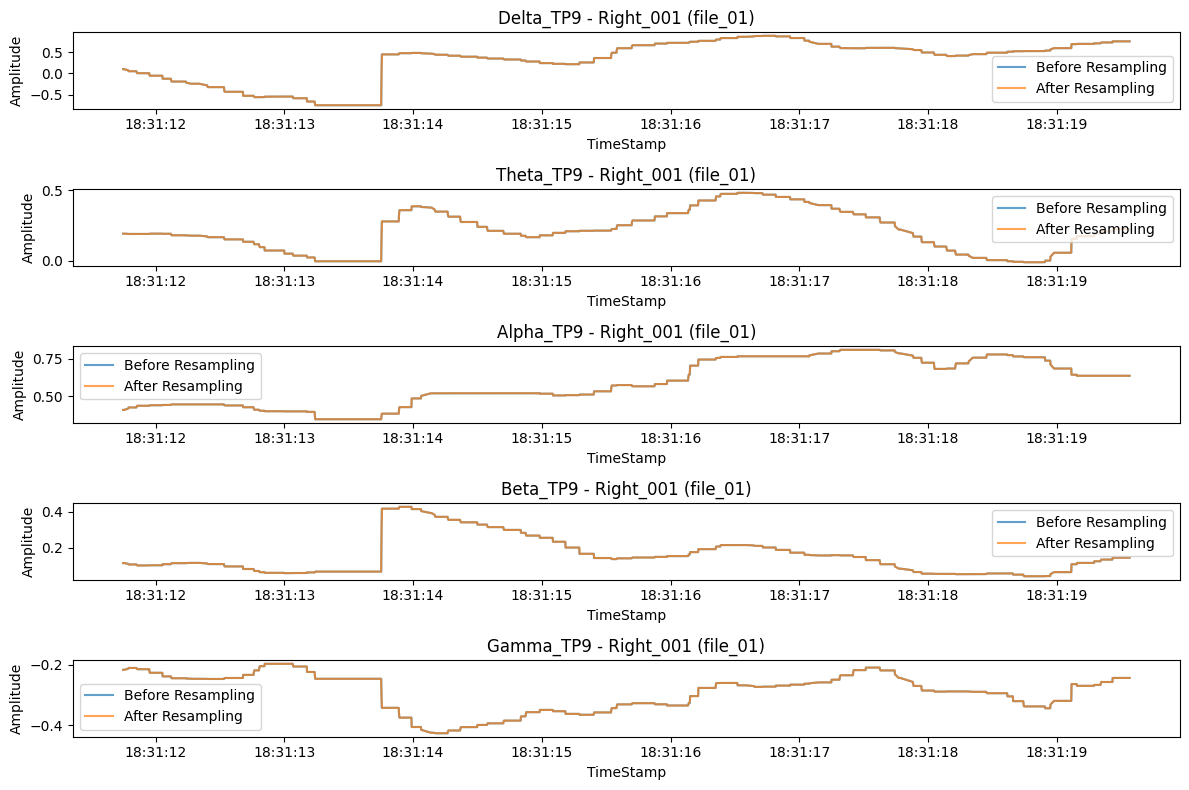

In [17]:
import matplotlib.pyplot as plt

def plot_eeg_bands(data_before, data_after, event_name, file_id, columns_to_plot, time_diff_threshold=0.1):
    """
    Plots EEG bands for a given event before and after resampling.
    :param data_before: Original data before resampling.
    :param data_after: Data after resampling.
    :param event_name: Name of the event to compare.
    :param file_id: File ID associated with the event.
    :param columns_to_plot: List of EEG band columns to plot.
    :param time_diff_threshold: Minimum time difference to plot for alignment (in seconds).
    """
    # Filter data for the given event and file ID
    event_data_before = data_before[(data_before['Event_Count'] == event_name) & (data_before['File_ID'] == file_id)]
    event_data_after = data_after[(data_after['Event_Count'] == event_name) & (data_after['File_ID'] == file_id)]

    # Further filter by time difference threshold
    event_data_before = event_data_before[event_data_before['Time_Diff'] <= time_diff_threshold * 1000]
    event_data_after = event_data_after[event_data_after['Time_Diff'] <= time_diff_threshold * 1000]

    # Plot EEG bands before and after resampling
    fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(12, 8))
    for i, col in enumerate(columns_to_plot):
        axs[i].plot(event_data_before['TimeStamp'], event_data_before[col], label='Before Resampling', alpha=0.7)
        axs[i].plot(event_data_after['TimeStamp'], event_data_after[col], label='After Resampling', alpha=0.7)
        axs[i].set_title(f"{col} - {event_name} ({file_id})")
        axs[i].legend()
        axs[i].set_xlabel("TimeStamp")
        axs[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Define the columns to plot
eeg_bands_to_plot = ['Delta_TP9', 'Theta_TP9', 'Alpha_TP9', 'Beta_TP9', 'Gamma_TP9']

# Call the function for two example events
plot_eeg_bands(df, data_resampled_corrected, 'Relax_001', 'file_01', eeg_bands_to_plot, time_diff_threshold=0.1)
plot_eeg_bands(df, data_resampled_corrected, 'Right_001', 'file_01', eeg_bands_to_plot, time_diff_threshold=0.1)


In [ ]:
data_resampled_corrected.to_csv("../data/resampled_output.csv", index=False)

-----

---
# Training
---

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np


data = data_resampled_corrected
# Identify EEG signal columns
eeg_columns = [col for col in data.columns if any(prefix in col for prefix in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])]

# Normalize EEG columns using Z-score normalization
scaler = StandardScaler()
data[eeg_columns] = scaler.fit_transform(data[eeg_columns])

data.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Beta_TP10,Gamma_TP9,Gamma_AF7,Gamma_AF8,Gamma_TP10,Same_Event_File,Time_Diff,Event_Count,Task_Labels,File_ID
0,2024-06-22 18:31:11.748000000,-1.104875,-1.155875,-1.066917,-1.309398,-0.883957,-0.738070,-0.608164,-1.215301,-1.450701,...,-1.020817,-0.849030,-0.920885,-0.699974,-1.639209,0.0,1.000000,Right_001,Right,file_01
1,2024-06-22 18:31:11.751906250,-1.104875,-1.155875,-1.066917,-1.309398,-0.883957,-0.738070,-0.608164,-1.215301,-1.450701,...,-1.020817,-0.849030,-0.920885,-0.699974,-1.639209,1.0,1.000000,Right_001,Right,file_01
2,2024-06-22 18:31:11.755812500,-1.107670,-1.155989,-1.069169,-1.313162,-0.884129,-0.740252,-0.608891,-1.219768,-1.449253,...,-1.022102,-0.848277,-0.920853,-0.698935,-1.637710,1.0,3.727293,Right_001,Right,file_01
3,2024-06-22 18:31:11.759718750,-1.111552,-1.156148,-1.072297,-1.318389,-0.884368,-0.743282,-0.609900,-1.225973,-1.447242,...,-1.023887,-0.847231,-0.920809,-0.697492,-1.635628,1.0,7.515200,Right_001,Right,file_01
4,2024-06-22 18:31:11.763625000,-1.115434,-1.156306,-1.075425,-1.323617,-0.884607,-0.746313,-0.610909,-1.232178,-1.445231,...,-1.025672,-0.846185,-0.920765,-0.696049,-1.633547,1.0,11.303107,Right_001,Right,file_01


In [20]:
def verify_standardization(df, eeg_columns):
    data = df
    results = {
        "Column": [],
        "Mean": [],
        "Std Dev": []
    }
    
    for col in eeg_columns:
        col_mean = data[col].mean()
        col_std = data[col].std()
        results["Column"].append(col)
        results["Mean"].append(col_mean)
        results["Std Dev"].append(col_std)
    
    return pd.DataFrame(results)


results_df = verify_standardization(data, eeg_columns)
print(results_df)



        Column          Mean   Std Dev
0    Delta_TP9  1.245225e-17  1.000001
1    Delta_AF7 -4.471980e-16  1.000001
2    Delta_AF8 -1.507805e-16  1.000001
3   Delta_TP10  2.403825e-16  1.000001
4    Theta_TP9  3.322855e-16  1.000001
5    Theta_AF7  1.245225e-17  1.000001
6    Theta_AF8  7.200646e-17  1.000001
7   Theta_TP10 -1.727072e-16  1.000001
8    Alpha_TP9 -3.667998e-16  1.000001
9    Alpha_AF7 -9.095553e-17  1.000001
10   Alpha_AF8  1.245225e-16  1.000001
11  Alpha_TP10  3.205100e-16  1.000001
12    Beta_TP9  6.529308e-16  1.000001
13    Beta_AF7  8.662432e-17  1.000001
14    Beta_AF8  1.158600e-16  1.000001
15   Beta_TP10 -1.905735e-16  1.000001
16   Gamma_TP9 -1.212740e-16  1.000001
17   Gamma_AF7 -6.605104e-17  1.000001
18   Gamma_AF8 -3.822298e-16  1.000001
19  Gamma_TP10  7.038226e-18  1.000001


In [21]:
def create_event_sequences(data, eeg_columns, event_column, label_column, file_column):
    """
    Creates event-based sequences for RNN.

    Parameters:
    - data: pandas.DataFrame, the preprocessed dataset.
    - eeg_columns: list of str, EEG feature columns.
    - event_column: str, column identifying the event count.
    - label_column: str, column for labels.
    - file_column: str, column for file IDs.

    Returns:
    - X: list of np.ndarrays, each array is a sequence of shape (time_steps, num_features).
    - y: list of labels for each event.
    """
    X, y = [], []
    grouped = data.groupby([event_column, file_column])

    for (event, file_id), group in grouped:
        # Extract EEG features and label
        X.append(group[eeg_columns].values)  # Sequence of EEG features
        y.append(group[label_column].iloc[0])  # Label for the event

    return X, y

# Define EEG columns and other parameters
eeg_columns = [col for col in data.columns if any(prefix in col for prefix in ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])]
event_column = "Event_Count"
label_column = "Task_Labels"
file_column = "File_ID"

# Create event-based sequences
X, y = create_event_sequences(data, eeg_columns, event_column, label_column, file_column)

# Check shapes
print(f"Number of events: {len(X)}")
print(f"Shape of first sequence: {X[0].shape}")
print(f"Labels: {set(y)}")


Number of events: 249
Shape of first sequence: (174, 20)
Labels: {'Right', 'Relax', 'Left'}


In [22]:
def create_fixed_length_windows(data, eeg_columns, event_column, label_column, file_column, window_size=256):
    """
    Creates fixed-length windows from event-based EEG sequences.

    Parameters:
    - data: pandas.DataFrame, the preprocessed dataset.
    - eeg_columns: list of str, EEG feature columns.
    - event_column: str, column identifying the event count.
    - label_column: str, column for labels.
    - file_column: str, column for file IDs.
    - window_size: int, length of each window in samples.

    Returns:
    - X: list of np.ndarrays, each array is a window of shape (window_size, num_features).
    - y: list of labels for each window.
    """
    X, y = [], []
    grouped = data.groupby([event_column, file_column])

    for (event, file_id), group in grouped:
        features = group[eeg_columns].values
        label = group[label_column].iloc[0]  # Event label

        # Create fixed-length windows
        for start in range(0, len(features) - window_size + 1, window_size):
            X.append(features[start:start + window_size])
            y.append(label)

    return np.array(X), np.array(y)

# Define parameters
event_column = "Event_Count"
label_column = "Task_Labels"
file_column = "File_ID"
window_size = 256

# Create fixed-length windows
X_windows, y_windows = create_fixed_length_windows(data, eeg_columns, event_column, label_column, file_column, window_size)


# Outputs
print(f"Number of windows: {X_windows.shape[0]}")
print(f"Shape of each window: {X_windows[0].shape}")
print(f"Labels: {set(y_windows)}")

Number of windows: 3152
Shape of each window: (256, 20)
Labels: {'Right', 'Relax', 'Left'}


In [23]:
rows_in_windows = 3152 * 256
rows_in_dataset = len(data[eeg_columns])

print(f"Rows in windows: {rows_in_windows}")
print(f"Rows in dataset: {rows_in_dataset}")
print(f"Unused rows: {rows_in_dataset - rows_in_windows}")


Rows in windows: 806912
Rows in dataset: 839944
Unused rows: 33032


In [24]:
original_label_counts = data[label_column].value_counts()
window_label_counts = pd.Series(y_windows).value_counts()

print(f"Original label distribution:\n{original_label_counts}")
print(f"Window label distribution:\n{window_label_counts}")


Original label distribution:
Task_Labels
Relax    618413
Right    136263
Left      85268
Name: count, dtype: int64
Window label distribution:
Relax    2355
Right     499
Left      298
Name: count, dtype: int64


In [25]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


def preprocess_labels(labels):
    """
    Converts string labels to numerical format and one-hot encodes them.
    """
    label_map = {'Right': 0, 'Left': 1, 'Relax': 2}
    numerical_labels = [label_map[label] for label in labels]
    return np.array(numerical_labels), to_categorical(numerical_labels, num_classes=3)

def resample_data(X, y, target_class, target_samples, random_state=42):
    """
    Resamples the dataset to balance the target class.
    """
    # Separate indices by class
    indices_by_class = {label: np.where(y == label)[0] for label in np.unique(y)}

    # Oversample minority classes
    new_indices = []
    for label, indices in indices_by_class.items():
        if label == target_class:
            new_indices.append(resample(indices, replace=True, n_samples=target_samples, random_state=random_state))
        else:
            new_indices.append(indices)
    new_indices = np.concatenate(new_indices)

    return X[new_indices], y[new_indices]



# Define target samples for balancing
target_samples = 1000  # Adjust based on desired balance

# Resample Right and Left classes
X_resampled, y_resampled = X_windows, y_windows  # Initial values
for target_class in ['Right', 'Left']:
    X_resampled, y_resampled = resample_data(X_resampled, y_resampled, target_class, target_samples)

# Convert labels to numerical format
y_resampled_num, y_resampled_one_hot = preprocess_labels(y_resampled)

print(f"New label distribution: {dict(zip(*np.unique(y_resampled, return_counts=True)))}")


2024-12-06 19:16:26.300839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/kabanda/Documents/unifr/SA2024/fuzzy_project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


New label distribution: {'Left': 1000, 'Relax': 2355, 'Right': 1000}


In [26]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.4516666666666667, 1: 0.6164189667374381, 2: 1.4516666666666667}


In [55]:

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output shapes
print(f"Training set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Validation set: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Training set: X_train shape: (3048, 256, 20), y_train shape: (3048, 3)
Validation set: X_val shape: (653, 256, 20), y_val shape: (653, 3)
Test set: X_test shape: (654, 256, 20), y_test shape: (654, 3)


---

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the RNN model
def build_rnn(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (256, 20)
num_classes = y_train.shape[1]  # 3 (Right, Left, Relax)

# Build the model
model = build_rnn(input_shape, num_classes)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256, 64)           21760     
                                                                 
 dropout_6 (Dropout)         (None, 256, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 34275 (133.89 KB)
Trainable params: 34275 (133.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/100
48/48 [==============================] - 28s 442ms/step - loss: 1.0886 - accuracy: 0.5335 - val_loss: 0.8929 - val_accuracy: 0.5789
Epoch 2/100
48/48 [==============================] - 18s 373ms/step - loss: 0.8565 - accuracy: 0.6703 - val_loss: 0.7295 - val_accuracy: 0.6799
Epoch 3/100
48/48 [==============================] - 21s 436ms/step - loss: 0.7469 - accuracy: 0.7241 - val_loss: 0.8242 - val_accuracy: 0.6539
Epoch 4/100
48/48 [==============================] - 21s 438ms/step - loss: 0.7095 - accuracy: 0.7395 - val_loss: 0.7109 - val_accuracy: 0.6998
Epoch 5/100
48/48 [==============================] - 19s 405ms/step - loss: 0.6662 - accuracy: 0.7507 - val_loss: 0.6982 - val_accuracy: 0.7259
Epoch 6/100
48/48 [==============================] - 20s 415ms/step - loss: 0.6499 - accuracy: 0.7651 - val_loss: 0.7032 - val_accuracy: 0.7152
Epoch 7/100
48/48 [==============================] - 18s 384ms/step - loss: 0.6103 - accuracy: 0.7792 - val_loss: 0.5889 - val_accuracy:

In [58]:
# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")


21/21 [==============================] - 1s 53ms/step - loss: 0.4955 - accuracy: 0.8532
Test Accuracy: 0.85


In [59]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Predict on the test set
y_pred_probs = model.predict(X_test)  # Get probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted classes
y_true = np.argmax(y_test, axis=1)  # True labels from one-hot encoded format

# Step 2: Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Right', 'Left', 'Relax']))

# Step 3: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


21/21 [==============================] - 2s 57ms/step
Classification Report:
              precision    recall  f1-score   support

       Right       0.73      0.92      0.81       144
        Left       0.93      0.75      0.83       143
       Relax       0.89      0.87      0.88       367

    accuracy                           0.85       654
   macro avg       0.85      0.84      0.84       654
weighted avg       0.86      0.85      0.85       654

Confusion Matrix:
[[132   2  10]
 [  7 107  29]
 [ 42   6 319]]


In [60]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    """
    Plots training and validation loss and accuracy curves.

    Parameters:
    - history: Keras History object returned by model.fit().
    """
    # Extract metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

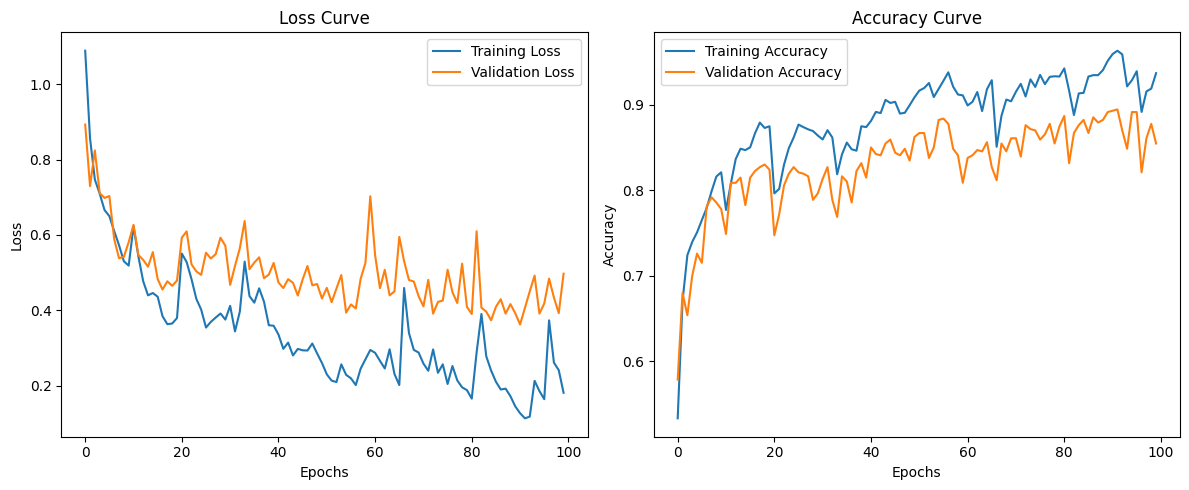

In [61]:
# Call the function to plot learning curves
plot_learning_curves(history)


In [87]:
# Assuming your trained model is named `model`
model.save("../models/classic_rnn_model.h5")
print("Model saved successfully as 'classic_rnn_model.h5'")


Model saved successfully as 'classic_rnn_model.h5'


----

# Fuzzy model

In [63]:
def gaussian_membership(x, mean, sigma):
    """Gaussian membership function."""
    return np.exp(-np.power(x - mean, 2.) / (2 * np.power(sigma, 2.)))

def fuzzify_features(data, feature_indices, num_levels=3):
    """
    Fuzzifies EEG features for each time step in a time-series dataset.

    Parameters:
    - data: np.ndarray, shape (num_windows, time_steps, num_features).
    - feature_indices: list of int, indices of features to fuzzify.
    - num_levels: int, number of fuzzy levels (e.g., low, medium, high).

    Returns:
    - np.ndarray: shape (num_windows, time_steps, num_fuzzy_features).
    """
    num_windows, time_steps, _ = data.shape
    fuzzified_data = []

    for col_idx in feature_indices:
        # Extract the feature for all windows and time steps
        feature_data = data[:, :, col_idx]

        # Compute membership functions
        mean = np.mean(feature_data)
        sigma = np.std(feature_data)
        levels = np.linspace(mean - 2 * sigma, mean + 2 * sigma, num_levels)

        # Fuzzify each level
        fuzzy_features = [
            gaussian_membership(feature_data, level, sigma) for level in levels
        ]
        fuzzified_data.extend(fuzzy_features)

    # Stack along the feature dimension
    fuzzified_data = np.stack(fuzzified_data, axis=-1)
    return fuzzified_data




In [64]:
# Get column indices for EEG features
eeg_column_indices = list(range(len(eeg_columns)))

# Fuzzify EEG features
fuzzified_features = fuzzify_features(X_train, eeg_column_indices)

# Combine original and fuzzy features
X_train_fuzzy = np.concatenate([X_train, fuzzified_features], axis=-1)
X_val_fuzzy = np.concatenate([X_val, fuzzify_features(X_val, eeg_column_indices)], axis=-1)
X_test_fuzzy = np.concatenate([X_test, fuzzify_features(X_test, eeg_column_indices)], axis=-1)

print(f"Shape of X_train_fuzzy: {X_train_fuzzy.shape}")


Shape of X_train_fuzzy: (3048, 256, 80)


In [65]:

# Update the Neuro-Fuzzy RNN to predict for the final time step only
def build_neuro_fuzzy_rnn(input_shape, num_classes):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),  # Predicts for the final time step
        Dropout(0.2),
        Dense(64, activation='relu'),  # Can mimic fuzzy inference
        Dropout(0.2),
        Dense(num_classes, activation='softmax')  # Crisp output
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Rebuild the model
input_shape = (X_train_fuzzy.shape[1], X_train_fuzzy.shape[2])
model_fuzzy = build_neuro_fuzzy_rnn(input_shape, num_classes)

# Train the model
history_fuzzy = model_fuzzy.fit(
    X_train_fuzzy, y_train,  # Labels align with one prediction per sequence
    validation_data=(X_val_fuzzy, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/100
48/48 [==============================] - 12s 184ms/step - loss: 1.0679 - accuracy: 0.5466 - val_loss: 0.8937 - val_accuracy: 0.5942
Epoch 2/100
48/48 [==============================] - 10s 200ms/step - loss: 0.9210 - accuracy: 0.6043 - val_loss: 0.9247 - val_accuracy: 0.5773
Epoch 3/100
48/48 [==============================] - 9s 187ms/step - loss: 0.9367 - accuracy: 0.6040 - val_loss: 0.8452 - val_accuracy: 0.6064
Epoch 4/100
48/48 [==============================] - 11s 236ms/step - loss: 0.8590 - accuracy: 0.6522 - val_loss: 0.8214 - val_accuracy: 0.6478
Epoch 5/100
48/48 [==============================] - 10s 214ms/step - loss: 0.7987 - accuracy: 0.6778 - val_loss: 0.7542 - val_accuracy: 0.6861
Epoch 6/100
48/48 [==============================] - 10s 209ms/step - loss: 0.7547 - accuracy: 0.7044 - val_loss: 0.7566 - val_accuracy: 0.6891
Epoch 7/100
48/48 [==============================] - 9s 188ms/step - loss: 0.7315 - accuracy: 0.7152 - val_loss: 0.6745 - val_accuracy: 0

In [66]:
# Evaluate the model
loss, accuracy = model_fuzzy.evaluate(X_test_fuzzy, y_test, verbose=1)
print(f"Neuro-Fuzzy RNN Test Accuracy: {accuracy:.2f}")

21/21 [==============================] - 1s 66ms/step - loss: 0.4228 - accuracy: 0.8777
Neuro-Fuzzy RNN Test Accuracy: 0.88


In [67]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Predict on the test set
y_pred_probs = model_fuzzy.predict(X_test_fuzzy)  # Use the fuzzy test set
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels to class indices

# Step 2: Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Right', 'Left', 'Relax']))

# Step 3: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


21/21 [==============================] - 2s 80ms/step
Classification Report:
              precision    recall  f1-score   support

       Right       0.79      0.87      0.83       144
        Left       0.92      0.85      0.88       143
       Relax       0.90      0.89      0.90       367

    accuracy                           0.88       654
   macro avg       0.87      0.87      0.87       654
weighted avg       0.88      0.88      0.88       654

Confusion Matrix:
[[125   1  18]
 [  4 121  18]
 [ 29  10 328]]


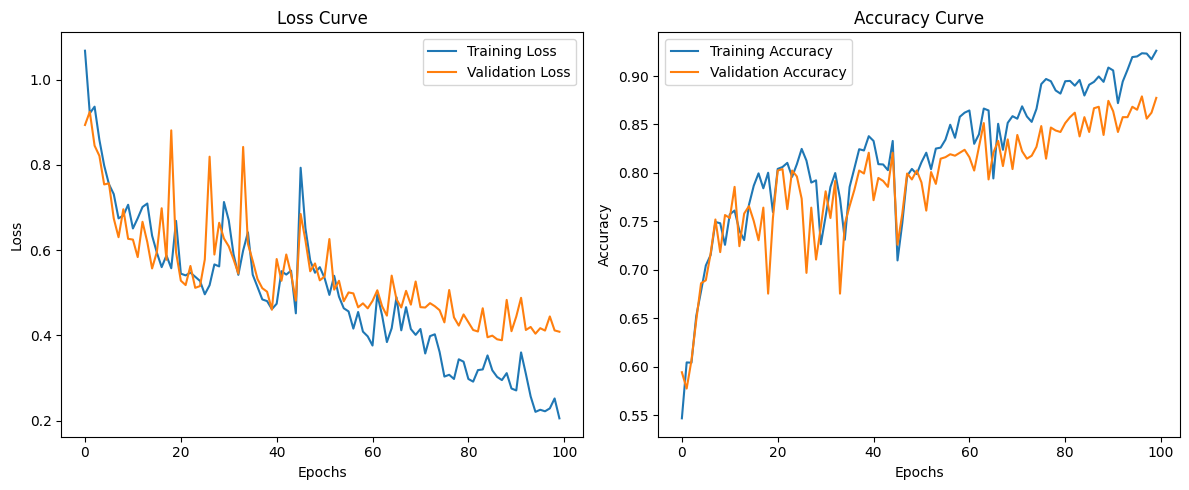

In [68]:
# Call the function to plot learning curves
plot_learning_curves(history_fuzzy)


In [86]:
# Assuming your trained model is named `model`
model_fuzzy.save("../models/rnn_fuzzy_features_model.h5")
print("Model saved successfully as 'rnn_fuzzy_features_model.h5'")

Model saved successfully as 'rnn_fuzzy_features_model.h5'


---


In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape


class FuzzyLayer(Layer):
    def __init__(self, num_fuzzy_levels):
        super(FuzzyLayer, self).__init__()
        self.num_fuzzy_levels = num_fuzzy_levels

    def build(self, input_shape):
        num_features = input_shape[-1]
        # Trainable centers for each fuzzy level and feature
        self.centers = self.add_weight(
            shape=(num_features, self.num_fuzzy_levels),
            initializer="random_normal",
            trainable=True
        )
        # Trainable sigmas for each fuzzy level and feature
        self.sigmas = self.add_weight(
            shape=(num_features, self.num_fuzzy_levels),
            initializer="ones",
            trainable=True
        )

    def call(self, inputs):
        # Apply Gaussian membership function
        x_expanded = tf.expand_dims(inputs, axis=-1)  # Expand for broadcasting
        gaussian_membership = tf.exp(
            -tf.square((x_expanded - self.centers) / self.sigmas)
        )
        # Flatten the fuzzy levels into the feature axis
        batch_size = tf.shape(gaussian_membership)[0]
        time_steps = tf.shape(gaussian_membership)[1]
        num_features = tf.shape(gaussian_membership)[2]
        num_levels = tf.shape(gaussian_membership)[3]
        
        # Reshape without unpacking
        return tf.reshape(gaussian_membership, (batch_size, time_steps, num_features * num_levels))




In [47]:
def build_optimized_fuzzy_rnn(input_shape, num_classes, num_fuzzy_levels, units=64):
    # Input layer for raw EEG features
    input_layer = Input(shape=input_shape)
    
    # Fuzzy layer with more fuzzy levels
    fuzzy_features = FuzzyLayer(num_fuzzy_levels=num_fuzzy_levels)(input_layer)
    
    # Concatenate raw features and fuzzy features
    combined_features = Concatenate()([input_layer, fuzzy_features])
    
    # LSTM layers with increased units
    x = LSTM(units, return_sequences=False)(combined_features)  # Output for final time step
    x = Dropout(0.3)(x)
    
    # Dense layers
    x = Dense(units, activation="relu")(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(num_classes, activation="softmax")(x)  # Classification output
    
    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Adjust parameters
num_fuzzy_levels = 1  # fuzzy levels
units = 64      # units



# Define the model
input_shape = (X_train_fuzzy.shape[1], X_train_fuzzy.shape[2])
model_optimized_fuzzy = build_optimized_fuzzy_rnn(input_shape, num_classes, num_fuzzy_levels)
model_optimized_fuzzy.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 80)]            0         []                            
                                                                                                  
 fuzzy_layer_3 (FuzzyLayer)  (None, 256, 80)              160       ['input_4[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 256, 160)             0         ['input_4[0][0]',             
                                                                     'fuzzy_layer_3[0][0]']       
                                                                                                  
 lstm_3 (LSTM)               (None, 64)                   57600     ['concatenate[0][0]']     

In [48]:
# Train the model
history_optimized_fuzzy = model_optimized_fuzzy.fit(
    X_train_fuzzy, y_train,
    validation_data=(X_val_fuzzy, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate the model
loss, accuracy = model_optimized_fuzzy.evaluate(X_test_fuzzy, y_test, verbose=1)
print(f"Optimized Neuro-Fuzzy RNN Test Accuracy: {accuracy:.2f}")


Epoch 1/100
48/48 [==============================] - 22s 388ms/step - loss: 1.1528 - accuracy: 0.5190 - val_loss: 0.9900 - val_accuracy: 0.5283
Epoch 2/100
48/48 [==============================] - 14s 297ms/step - loss: 1.0287 - accuracy: 0.5436 - val_loss: 0.8785 - val_accuracy: 0.5528
Epoch 3/100
48/48 [==============================] - 17s 353ms/step - loss: 0.9844 - accuracy: 0.5669 - val_loss: 0.9126 - val_accuracy: 0.5574
Epoch 4/100
48/48 [==============================] - 12s 258ms/step - loss: 0.9495 - accuracy: 0.5879 - val_loss: 0.8431 - val_accuracy: 0.5651
Epoch 5/100
48/48 [==============================] - 13s 264ms/step - loss: 1.0440 - accuracy: 0.5610 - val_loss: 1.0401 - val_accuracy: 0.4855
Epoch 6/100
48/48 [==============================] - 13s 276ms/step - loss: 1.1116 - accuracy: 0.5338 - val_loss: 1.0198 - val_accuracy: 0.5329
Epoch 7/100
48/48 [==============================] - 14s 300ms/step - loss: 1.0881 - accuracy: 0.5515 - val_loss: 0.9758 - val_accuracy:

In [51]:
# Step 1: Predict on the test set
y_pred_probs = model_optimized_fuzzy.predict(X_test_fuzzy)  # Use the fuzzy test set
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels to class indices

# Step 2: Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Right', 'Left', 'Relax']))

# Step 3: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

21/21 [==============================] - 5s 180ms/step
Classification Report:
              precision    recall  f1-score   support

       Right       0.74      0.74      0.74       144
        Left       0.86      0.71      0.78       143
       Relax       0.82      0.88      0.85       367

    accuracy                           0.81       654
   macro avg       0.81      0.78      0.79       654
weighted avg       0.81      0.81      0.81       654

Confusion Matrix:
[[106   5  33]
 [  5 101  37]
 [ 32  11 324]]


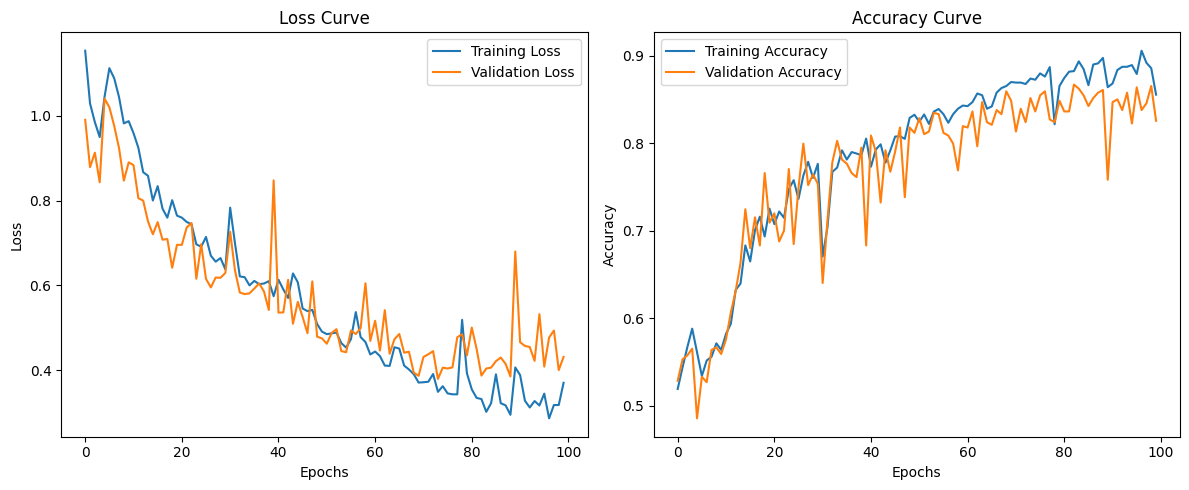

In [ ]:
# Call the function to plot learning curves
plot_learning_curves(history_optimized_fuzzy)


In [ ]:
# Assuming your trained model is named `model`
model_optimized_fuzzy.save("../models/fuzzy_layer_rnn_model.h5")
print("Model saved successfully as 'fuzzy_layer_rnn_model.h5'")


In [89]:
%pip freeze > "requirements.txt"


zsh:1: no such file or directory: requirements.txt
Note: you may need to restart the kernel to use updated packages.
